In [1]:
!pip install wordninja
!pip install num2words

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from sklearn import preprocessing
import wordninja
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import num2words
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 7.0 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541552 sha256=8cf336926db4773847fd81c8120b244feacafafcea06996598b4b51a7fb0a5d7
  Stored in directory: /root/.cache/pip/wheels/a6/08/fb/98831d1c2702c8352a339f91104515eab5d7906d4118eeeaed
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=aa7f362b4864f0b8f396504c7473a2fe0cadaca1dd9b627dd3f3b16ebca24c47
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Mounted at /content/drive


In [2]:
# Specify the path to our shared drive. Should work for all of us.
path = '/content/drive/Shareddrives/ANLY590_GROUP_4_PROJECT'

In [3]:
df = pd.read_csv(path + "/data/merged_data/joined_data_without_position.csv", index_col=0)

## Preprocessing

In [4]:
# Create win dummy variable.
df['win'] = np.where(df['race_number'] >= 3, 1, 0)

# Drop the redundant variables.
df = df.drop(['position_at_finish', 'post_time', 'distance_id'], axis = 1)

# Convert the race number as string.
df['race_number'] = df['race_number'].astype('str')

# Convert to float and fill NA
df['day_since_last_race'] = df['day_since_last_race'].apply(lambda x : x[:-5] if x is not np.nan else np.nan).astype('float').fillna(0)

# Fill the comments column with string None.
df['Comments'] = df['Comments'].fillna('None')

In [5]:
# Preprocess the comments. 
res = []
tokenizer = RegexpTokenizer(r'\w+')
for i in df.Comments:
  if type(i) == str:
    re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), i)
    phrase_list = tokenizer.tokenize(i)
    splited_tokens = [wordninja.split(i) for i in phrase_list]
    flat_splited_tokens = [j for sublist in splited_tokens for j in sublist]
    res.append(flat_splited_tokens)    
  else:
    res.append(np.nan)

df['Comments'] = res

In [6]:
# Convert all numerical columns to float.
for i in df.columns:
  if df[i].dtype == int:
    df[i] = df[i].astype('float')

Here I concat all three outcome variables, so when training, be mindful about the column index

In [7]:
df.columns

Index(['track_id', 'race_date', 'race_number', 'program_number',
       'weight_carried', 'jockey', 'odds', 'course_type', 'track_condition',
       'run_up_distance', 'race_type', 'purse', 'last_race_track',
       'day_since_last_race', 'Comments', 'seconds_in_race', 'humidity',
       'precipcover', 'precip', 'temp', 'maxt', 'cloudcover', 'weathertype',
       'snow', 'win'],
      dtype='object')

In [8]:
# Separate the target data and others.
# dropping some extra variables to fix info leakage
target = df[['win']]
data = df.drop(['win', 'odds', 'purse','Comments', "seconds_in_race", "race_number", "race_date"], axis = 1)

In [9]:
data.shape

(15081, 18)

In [10]:
# Separate the training data to numericals, categoricals and the text.
cat_col = []
num_col = []

for i in data.columns:
  if data[i].dtype == object:
    cat_col.append((i, data.columns.get_loc(i)))

  elif data[i].dtype == float:
    num_col.append((i, data.columns.get_loc(i)))


In [11]:
# Label encode the categorical variables and standarlize the numericals. 
for i in cat_col:
  le = preprocessing.LabelEncoder()
  data[i[0]] = le.fit_transform(data[i[0]])

num_col_name = [j[0] for j in num_col]
cat_col_name = [j[0] for j in cat_col]

se = preprocessing.StandardScaler()
data[num_col_name] = se.fit_transform(data[num_col_name])

se = preprocessing.StandardScaler()
#target[['odds', 'purse']] = se.fit_transform(target[['odds', 'purse']])

In [12]:
# Create a dict for the unique categories and the desired embedding dimensions for each categorical variable. 
# Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
def create_embedding_dim():

  embedding_dim = {}
  for i in range(len(cat_col)):
    embedding_dim[cat_col[i][0]] = (data[cat_col[i][0]].nunique(), min(50, data[cat_col[i][0]].nunique() //2 ))

  return embedding_dim

In [13]:
embedding_dim = create_embedding_dim()

In [14]:
# Convert the comments column to tokes and pad each sequence.

max_words = 1133 # The length of the vocabulary.

# Make the units matrices.
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(df['Comments'])
data_text = tokenizer.texts_to_sequences(df['Comments'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Maximum length for a vector.
maxlen = 15

# Pad the sequence.
data_text = pad_sequences(data_text, maxlen=maxlen)

print('Shape of data tensor:', data_text.shape)

Found 1133 unique tokens.
Shape of data tensor: (15081, 15)


In [15]:
# Concat the regular features with text features. Transform them all to numpy array.
data = np.concatenate((np.asarray(data), data_text), axis=1)
target = np.asarray(target)

## Modeling

Here I build the model mainly with a class and Keras functional API for it will allow us to build a more flexible model.

In [16]:
class NN():

    def __init__(self, cat_col, cat_col_name, embedding_dim):
      # For each categorical variable, we need to specify a input layer and a embedding layer. So I created them all by iteratively specifying them as attributes.
      for i in cat_col_name:

        # These are all the input layers for the cat_col
        setattr(self, i + '_input', keras.Input(shape=(1,), name=i))

        #Then we embed them by the dimensions we created earlier.
        setattr(self, i + '_embedding', layers.Embedding(embedding_dim[i][0], embedding_dim[i][1], input_length = 1)(getattr(self, i + '_input')))

        # Next we rehsape them so that they can be concatenated with other layers' output.
        setattr(self, i + '_reshape', layers.Reshape(target_shape=(embedding_dim[i][1], ))(getattr(self, i + '_embedding')))

      # Input for the numerical variables.
      setattr(self, 'num_input', keras.Input(shape=(len(num_col),), name = 'num_col'))
      setattr(self, 'num_features', layers.Dense(64, activation='relu')(getattr(self, 'num_input')))

      # Input and embedding layers for the texts variable.
      setattr(self, 'text_input', keras.Input(shape=(None,), name = 'text'))
      setattr(self, 'text_embedding', layers.Embedding(1000, 64)(getattr(self, 'text_input')))

    def concat(self):

      # LSTM layer for the text data.
      text_features = layers.LSTM(128)(getattr(self, 'text_embedding'))
      
      # Reshape the text output so that the outputs can be concatenated
      text_features = layers.Reshape(target_shape=(128, ))(text_features)

      # Concatenate all outputs from previous layers.
      x = layers.concatenate([getattr(self, i + '_reshape') for i in cat_col_name] + [getattr(self, 'num_features')] + [text_features])

      # More dense layers.
      x = layers.Dense(128, activation="relu", name="dense1", kernel_initializer='normal',
                       kernel_regularizer=regularizers.l2(0.00001))(x)
      x = layers.Dropout(0.2)(x)
      x = layers.Dense(256, activation="relu", name="dense2", kernel_initializer='normal',
                       kernel_regularizer=regularizers.l2(0.00001))(x)
      x = layers.Dropout(0.2)(x)
      x = layers.Dense(128, activation="relu", name="dense3", kernel_initializer='normal',
                       kernel_regularizer=regularizers.l2(0.00001))(x)
      x = layers.Dense(64, activation="relu", name="dense4", kernel_initializer='normal',
                       kernel_regularizer=regularizers.l2(0.00001))(x)
      pred = layers.Dense(1,  name="prediction")(x)

      # Compiling the model by specifying the inputs and outputs.
      model = keras.Model(
      inputs=[getattr(self, i + '_input') for i in cat_col_name] + [getattr(self, 'num_input')] + [getattr(self, 'text_input')],
      outputs=[pred])

      return model

For different outcome variables, we can just change the layer that generate the prediction, the loss and the metric. 

For hyperparameter tuning, I think apart from changing the regular ones, we can also all more layers. Maybe some dense layer after the categorical embedding layer. 

In [26]:
from tensorflow.keras import optimizers

def build_model(cat_col, cat_col_name, embedding_dim):

  # Instantiate the model.
  model = NN(cat_col, cat_col_name, embedding_dim)
  model = model.concat()
  
  opt = optimizers.Adam(learning_rate=0.01)
  model.compile(
    optimizer=opt,
    loss={
        "prediction": keras.losses.BinaryCrossentropy(from_logits=True)
        #"prediction": keras.losses.mean_squared_error 
    },
    #metrics=['mae']
    metrics=['acc']
)
  return model

In [27]:
# Instantiate the model.
model = build_model(cat_col, cat_col_name, embedding_dim)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 track_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 program_number (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 jockey (InputLayer)            [(None, 1)]          0           []                               
                                                                                            

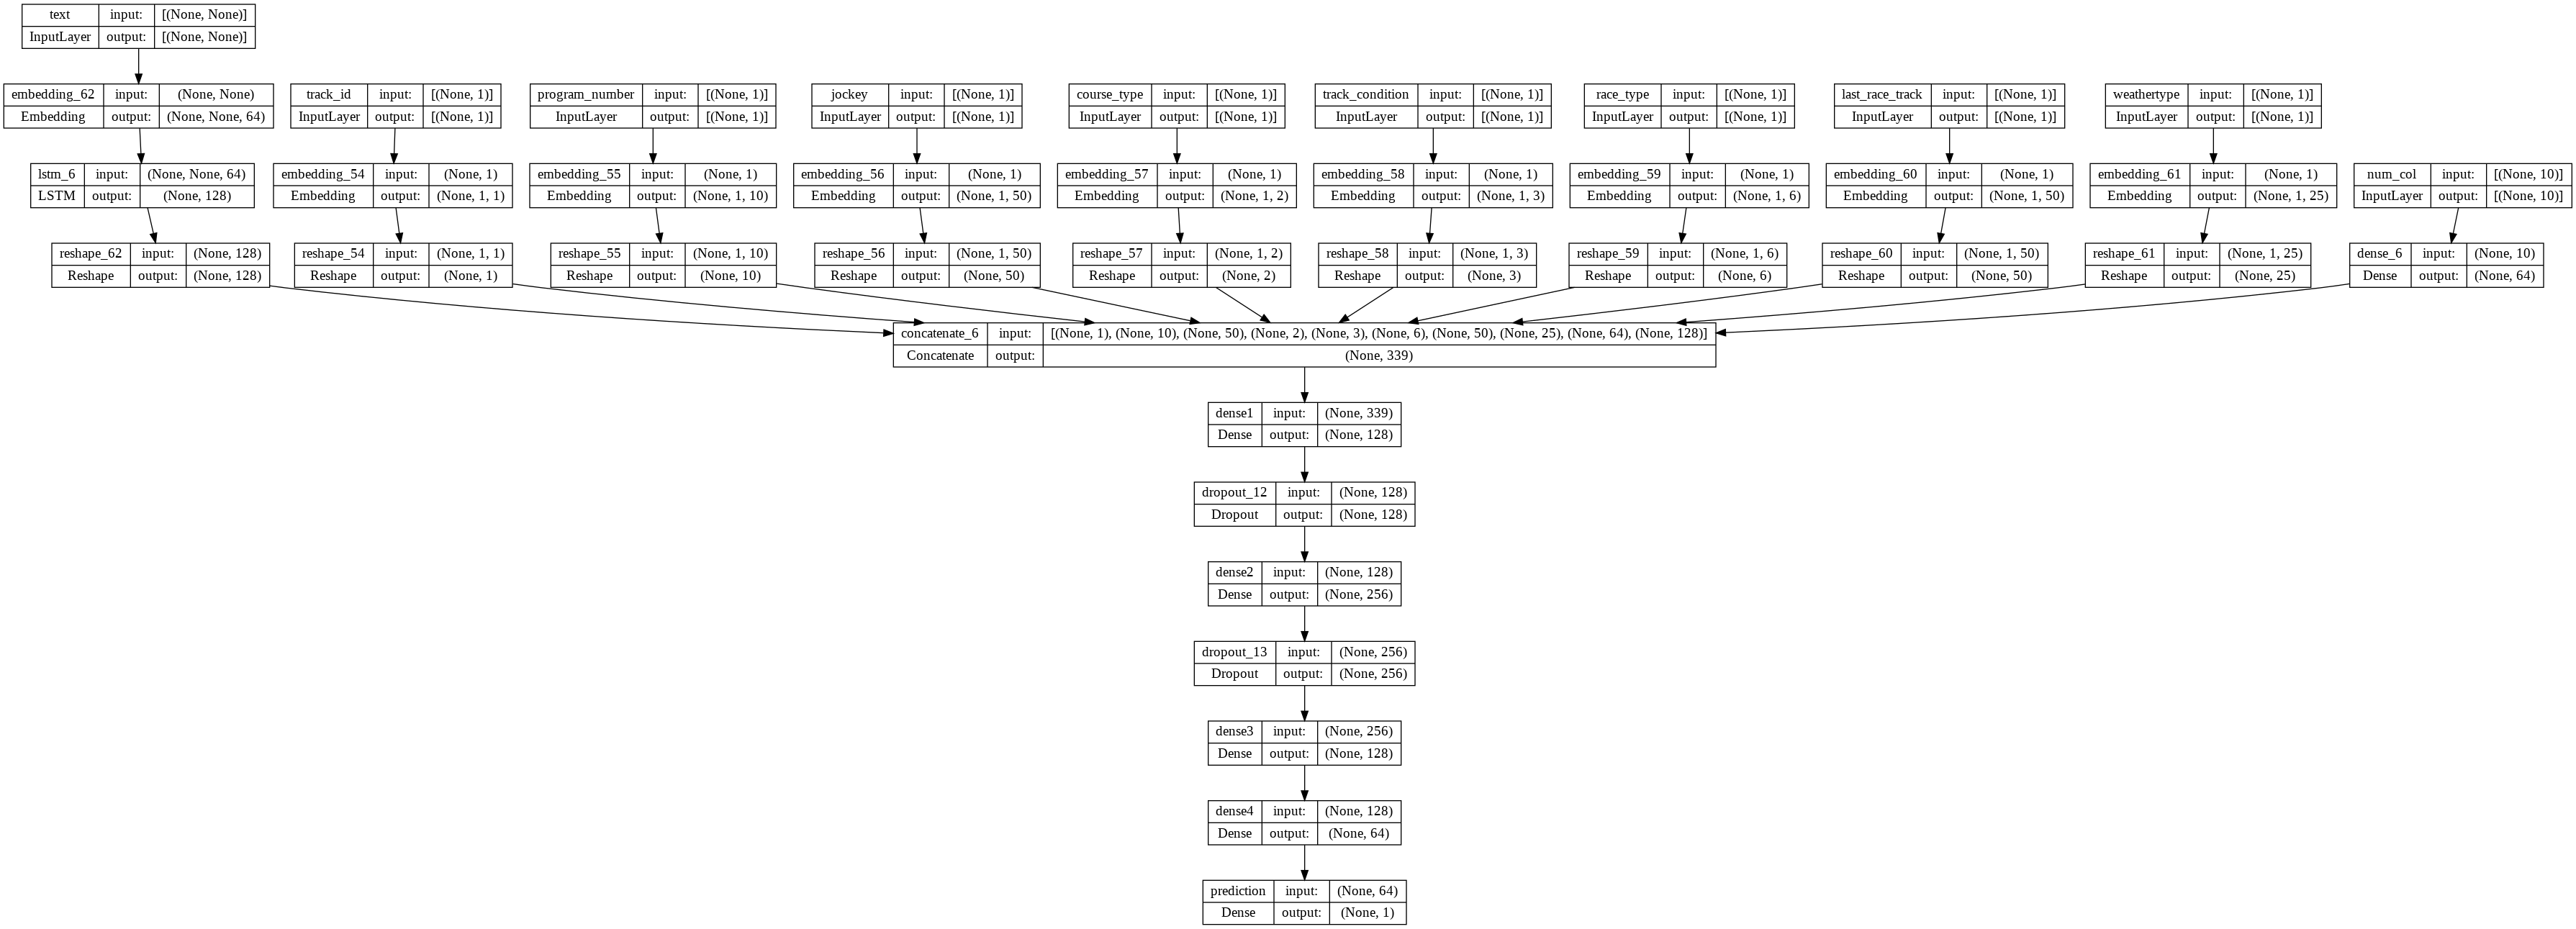

In [28]:
# Check the dimensions and the graph of layers.
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [29]:
# This function aims to turn the whole data numpy array to the form that the model can take.
def create_data(whole_data):

  output = {}
  for i in cat_col:
    output[i[0]] = whole_data[:,i[1]]
  output['num_col'] = whole_data[:,[j[1] for j in num_col]]
  output['text'] = whole_data[:, -15:]

  return output

In [30]:
# Here I did a 4-fold cross validation and log the loss and metric.
# Split the data.
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

# Specify the hyperparameters.
k=4
num_val_samples = len(x_train) // k 
num_epochs = 50
batch_size = 1000
all_train_histories = [] 
all_val_histories = []


for i in range(k):
    print('processing fold #', i + 1)
    
    # Create the validation data and recreate the training data.
    val_data_temp = x_train[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets_temp = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]], axis=0)

    #Create the model and train.
    model = build_model(cat_col, cat_col_name, embedding_dim)

    # Create the model usable data inputs.
    train_data = create_data(partial_train_data)
    val_data = create_data(val_data_temp)

    # Train the model.
    history = model.fit(
    train_data,
    {"prediction": partial_train_targets[:, -1]},
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(val_data, val_targets_temp[:, -1])
)
    
    # Log the loss
    train_history = history.history['acc']
    val_history = history.history['val_acc']
    all_train_histories.append(train_history)
    all_val_histories.append(val_history)

processing fold # 1
Epoch 1/50
10/10 [==============================] - 4s 91ms/step - loss: 0.6861 - acc: 0.4158 - val_loss: 0.5899 - val_acc: 0.1993
Epoch 2/50
10/10 [==============================] - 0s 24ms/step - loss: 0.5249 - acc: 0.7182 - val_loss: 0.4981 - val_acc: 0.8047
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 0.4833 - acc: 0.8075 - val_loss: 0.4735 - val_acc: 0.8047
Epoch 4/50
10/10 [==============================] - 0s 18ms/step - loss: 0.4579 - acc: 0.8075 - val_loss: 0.4518 - val_acc: 0.8047
Epoch 5/50
10/10 [==============================] - 0s 18ms/step - loss: 0.4390 - acc: 0.8075 - val_loss: 0.4496 - val_acc: 0.8047
Epoch 6/50
10/10 [==============================] - 0s 18ms/step - loss: 0.4265 - acc: 0.8075 - val_loss: 0.4546 - val_acc: 0.8047
Epoch 7/50
10/10 [==============================] - 0s 18ms/step - loss: 0.4181 - acc: 0.8075 - val_loss: 0.4967 - val_acc: 0.8047
Epoch 8/50
10/10 [==============================] - 0s 18ms/ste

In [31]:
# Calculate the average accuracy acorss validations.
average_train_history = [
    np.mean([x[i] for x in  all_train_histories]) for i in range(num_epochs)]

average_val_history = [
    np.mean([x[i] for x in all_val_histories]) for i in range(num_epochs)]

In [32]:
# Define a function to smooth the history of loss.
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

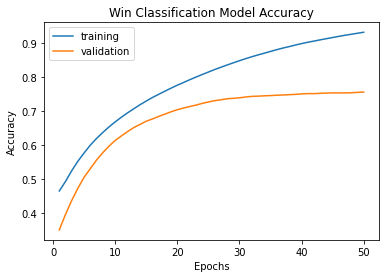

In [33]:
smooth_history1 = smooth_curve(average_train_history)
smooth_history2 = smooth_curve(average_val_history)

# Plot the smmoothed history.
plt.plot(range(1, len(smooth_history1) + 1), smooth_history1, label = 'training')
plt.plot(range(1, len(smooth_history2) + 1), smooth_history2, label = 'validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Win Classification Model Accuracy")
plt.legend()
plt.savefig('NN_acc_win.png')
plt.show()

In [34]:
train_data = create_data(x_train)
test_data = create_data(x_test)

# Train the final model.
model = build_model(cat_col, cat_col_name, embedding_dim)
model.fit(
    train_data,
    {"prediction": y_train[:, -1]},
    epochs=50,
    batch_size=1000)

# Print out the final results.
model.evaluate(train_data, y_train[:, -1])
model.evaluate(test_data, y_test[:, -1])

Epoch 1/50
13/13 [==============================] - 3s 16ms/step - loss: 0.6418 - acc: 0.4136
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 0.4942 - acc: 0.8068
Epoch 3/50
13/13 [==============================] - 0s 15ms/step - loss: 0.4684 - acc: 0.8068
Epoch 4/50
13/13 [==============================] - 0s 12ms/step - loss: 0.4427 - acc: 0.8068
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 0.4295 - acc: 0.8070
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 0.4195 - acc: 0.7742
Epoch 7/50
13/13 [==============================] - 0s 12ms/step - loss: 0.4056 - acc: 0.7909
Epoch 8/50
13/13 [==============================] - 0s 13ms/step - loss: 0.3954 - acc: 0.7871
Epoch 9/50
13/13 [==============================] - 0s 13ms/step - loss: 0.3956 - acc: 0.7843
Epoch 10/50
13/13 [==============================] - 0s 13ms/step - loss: 0.3871 - acc: 0.7948
Epoch 11/50
13/13 [==============================] - 0s 15m

[1.6051437854766846, 0.7964865565299988]